## Methodology 3 : deep learning with fastai

There are three reasons why we choose fastai library.
Firstly, fastai is a one kind of transfer learning. As we all know, transfer learning is always used in computer vision but now we want to implement it into NLP.
Secondly, the advantage of using pretrained model is we are easy to tune parameters and save running time.
Finally, it can overcome the limitation of word embedding in the neural network. 

### 3.1 load dataset

In [1]:
from fastai import *
from fastai.text import *
import pandas as pd
import nltk 
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df= pd.read_csv('/content/drive/My Drive/AI/AI_Project_tweet/train.csv')
test_df= pd.read_csv('/content/drive/My Drive/AI/AI_Project_tweet/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 3.2 building the language model

In [4]:
path = Path('/content/drive/My Drive/AI/NLP')
df_lm = pd.DataFrame({
    "text" : np.concatenate((train_df["text"].values, test_df["text"].values), axis = 0) 
})

In here, using all dataset trains the language model. Because it is not important to the language model to classifier the label, the main aim of the language model is to understand the tweet sentences

In [5]:
nltk.download('stopwords') 
stop_words = stopwords.words('english')
# tokenization 
tokenized_sen = df_lm['text'].apply(lambda x: x.split()) 
# remove stop-words 
tokenized_sen = tokenized_sen.apply(lambda x:[item for item in x if 
                                    item not in stop_words]) 
# connected by space
token_sen = [] 
for i in range(len(df_lm)):
    t =' '.join(tokenized_sen[i]) 
    token_sen.append(t) 
df_lm['text'] = token_sen

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


there are common operation for data proprecessing such as tokenizing the sentence and removing the stop words. And then transforms the dataframe into databunch.

In [6]:
# transfer the dataframe to databunch
data_lm = (TextList.from_df(df_lm).split_by_rand_pct(0.1).label_for_lm().databunch(bs=32))
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,". 20 closed xxunk due xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding streets xxmaj xxunk , xxmaj colorado xxmaj springs areas xxbos i 'm top hill i see fire woods ... xxbos xxmaj there 's emergency evacuation happening building across street xxbos xxmaj three people died heat wave far xxbos # raining # flooding # xxmaj"
1,xxmaj is n't funny ? ! xxmaj where get xxunk staff xxup xxunk ? xxbos * * xxup official xxup vid * * # xxunk > > > https : / / t.co / xxunk > > > @trubgme > > > # xxup armageddon xxmaj xxunk xxmaj soon ! ! xxbos xxmaj well done xxmaj xxunk xxmaj fingers crossed xxmaj xxunk tomorrow night ! xxmaj armageddon eh xxrep 4
2,xxup cool # xxunk xxbos pic blaze fort kids look like xxunk xxunk face like xxrep 6 ? http : / / t.co / xxunk xxbos looks like year writing computers ahead . http : / / t.co / xxunk xxbos xxunk letting know xxbos xxunk i 'm mad xxunk name & & blaze . xxbos xxunk yeah i know blaze blue do nt twitter lol i xxunk weeks ago
3,womens xxmaj satchel xxmaj xxunk xxmaj chain xxmaj xxunk xxmaj cross xxmaj body xxmaj multi xxmaj colour xxmaj shoulder xxmaj bags xxmaj blue http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj lab today ready body bags . ? ? xxbos xxmaj bitches xxunk pics bags bigger whole body xxrep 6 ? xxbos xxmaj womens xxmaj buckle xxmaj casual xxmaj stylish xxmaj shoulder
4,honest . xxmaj if people want go xxunk let use hands feet . xxmaj no casualties . xxbos xxmaj afghanistan : xxup xxunk xxmaj reports ' xxmaj record - xxmaj high xxmaj levels ' xxmaj civilian xxmaj casualties xxmaj in news xxmaj afghanistan xxmaj united ... http : / / t.co / xxunk xxbos xxmaj need stop xxunk things everything eventually explodes casualties keep getting higher higher xxbos xxmaj xxunk


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 5.25E-02


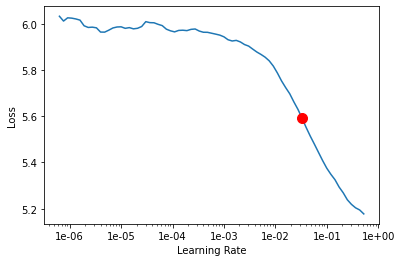

In [7]:
# load the pre-trained model AWD_LSTM
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
# find learning rate and plot the results
learn.lr_find()
learn.recorder.plot(skip_end=15, suggestion = True)

In [8]:
# explore the performance when lr = 1e-2
learn.fit_one_cycle(5, 1e-2, moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,4.460267,3.503300,0.433807,00:09
1,3.399246,3.025649,0.494237,00:10
2,2.918878,2.918816,0.511404,00:10
3,2.596895,2.884218,0.517411,00:10
4,2.439322,2.886328,0.517289,00:09


In this step, we just train current layer with 1e-2 learning rate. The average accuracy is about 50%, which means the language model use two times to prodict the next words well. Finally, we use this parameters to train all layers and save the model.

In [9]:
learn.unfreeze() # train all layers
learn.lr_find()
learn.fit_one_cycle(5, 1e-2, moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,2.554381,3.343880,0.450325,00:14
1,2.611840,2.882303,0.520657,00:14
2,2.303418,2.850451,0.537216,00:13
3,1.722186,2.956556,0.540787,00:13
4,1.142578,3.084637,0.540016,00:13


In [10]:
learn.save_encoder('fine_tuned_enc')
path

PosixPath('/content/drive/My Drive/AI/NLP')

### 3.3 building the classifier

In [11]:
# split the dataset into train and validation
X_train, X_val = train_test_split(train_df, test_size = 0.3)
X_train.shape, X_val.shape

((5329, 5), (2284, 5))

In [12]:
# transfer dataframe to databunch
data_classifier = (TextDataBunch.from_df('.', X_train, X_val, test_df, text_cols = "text", label_cols = "target", vocab = data_lm.vocab))

In [13]:
data_classifier.show_batch()

text,target
xxbos _ xxunk xxrep 5 ? xxup retweet xxunk xxrep 7 ? xxunk xxrep 5 ? xxup follow xxup all xxup who xxup rt xxunk xxrep 7 ? xxunk xxrep 5 ? xxup xxunk xxunk xxrep 7 ? xxunk xxrep 5 ? xxup xxunk xxup with xxunk xxrep 7 ? xxunk xxrep 5 ? xxup follow ? xxunk # xxup xxunk xxunk # xxup ty,0
xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk xxunk xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
xxbos xxup info xxup s. xxup xxunk : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup xxunk xxup xxunk . xxup xxunk 05 . xxup curfew xxup in xxup xxunk xxup until xxunk xxup xxunk xxup xxunk xxup foxtrot 5 & & xxup foxtrot 6 xxup xxunk . xxup xxunk : 10 .,0
xxbos xxmaj no # news of # hostages in # xxmaj libya xxunk http : / / t.co / xxunk xxunk # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
xxbos xxmaj no # news of # hostages in # xxmaj libya xxunk http : / / t.co / xxunk xxunk # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1


In [14]:
# upload the pre-trained classifier model and load the language model 
learn = text_classifier_learner(data_classifier, AWD_LSTM)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5329 items)
x: TextList
xxbos xxmaj this night just blew up xxunk,xxbos ? xxmaj high xxmaj skies - xxmaj burning xxmaj buildings ? http : / / t.co / xxunk # nowplaying,xxbos [ xxmaj tropical xxmaj cyclone xxmaj info ] xxup soudelor xxunk xxunk maximum wind speed : 45 m / s maximum wind xxunk speed : 60 m / s http : / / t.co / xxunk,xxbos xxmaj photo : xxunk : xxmaj xxunk around the rubble . http : / / t.co / xxmaj xxunk,xxbos xxup mh370 victim 's family xxunk the media was told about wreckage xxunk first http : / / t.co / xxunk
y: CategoryList
0,0,1,0,1
Path: .;

Valid: LabelList (2284 items)
x: TextList
xxbos xxmaj because you watched : xxmaj xxunk i xxmaj blew up the xxmaj economy xxunk xxmaj we xxmaj recommend : xxmaj the xxmaj xxunk xxmaj xxunk of xxmaj xxunk xxunk # xxunk # xxunk # xxunk,xxbos xxup xxunk : xxmaj dealing with disaster - http : / / t.co / xxunk,xxbos xxmaj due to the rainstorm last night cupcake xxunk is happenin

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 1.74E-02


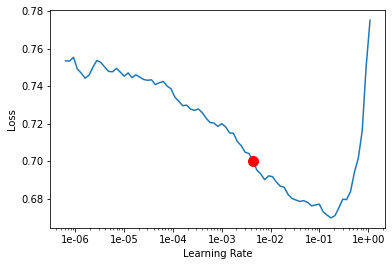

In [15]:
# find the best learning rate
learn.lr_find()
learn.recorder.plot(suggestion= True)

In [16]:
# fit the model with lr = 1e-4
learn.fit_one_cycle(5, 1e-4, moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.713475,0.617090,0.655867,00:04
1,0.646468,0.537674,0.728109,00:04
2,0.613230,0.515506,0.745622,00:04
3,0.601102,0.497700,0.763135,00:04
4,0.593278,0.490965,0.766638,00:04


In [17]:
# fit the two layers manually
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.579835,0.453876,0.792032,00:04
1,0.561845,0.457375,0.797723,00:04
2,0.543860,0.455686,0.799037,00:04
3,0.524237,0.438456,0.806918,00:04
4,0.517989,0.439768,0.806042,00:04


In [18]:
# fit the three layers manually
learn.freeze_to(-3)
learn.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.519209,0.426783,0.809107,00:07
1,0.505173,0.439757,0.802102,00:07
2,0.505699,0.418737,0.814361,00:07
3,0.478351,0.423070,0.812609,00:07
4,0.476384,0.416397,0.815236,00:07


Similarly, the dataframe is transformed to databunch and figure out a better learning rate. when lr=1e-4, it works not bad, when we train the current layer. And then using these paraters trains two layers manually. The acurracy is about 79%, when we manually train three layers, the accuracy increase slightly to 80%. Finally, using these parameters train all layers of the classifier

In [19]:
# using this parameters to fit the whole model
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.458048,0.417455,0.815236,00:09
1,0.459903,0.417265,0.813485,00:09
2,0.463173,0.413089,0.816988,00:10
3,0.461818,0.414213,0.817426,00:09
4,0.463510,0.414786,0.819615,00:09
5,0.456715,0.413505,0.821804,00:09
6,0.451871,0.414440,0.822242,00:09
7,0.448894,0.414511,0.821804,00:08
8,0.450035,0.419253,0.816988,00:08
9,0.449955,0.412684,0.821804,00:08


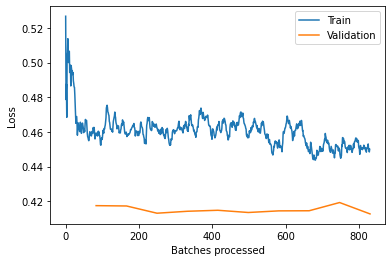

In [20]:
# showing the loss values
learn.recorder.plot_losses()

In the end, the average accuracy is about 81%. And the loss train decreases gradually and converge to approximatly 0.45. 